In [2]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.0 MB/s eta 0:00:00
time: 302 µs (started: 2023-12-12 00:08:24 +00:00)


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
np.random.seed(123)

In [2]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and std
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

100%|██████████| 170498071/170498071 [00:05<00:00, 29571331.96it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
mean, std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [5]:

cifar10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))


In [6]:

cifar10_val = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))


In [7]:
first_image, label = cifar10[0]
print(first_image.shape)

torch.Size([3, 32, 32])


In [8]:
train_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False, num_workers=2)

In [9]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

#problem 1.a

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

# model = Net().to(device)

In [11]:
model = Net().to(device)

In [12]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18354, [432, 16, 1152, 8, 16384, 32, 320, 10])

In [13]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 2 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))


In [14]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-12-12 03:16:31.995224 Epoch 1, Training loss 2.0680643684418913
2023-12-12 03:16:46.827905 Epoch 2, Training loss 1.7975568507638429
2023-12-12 03:17:16.462655 Epoch 4, Training loss 1.5253267736386156
2023-12-12 03:17:46.259600 Epoch 6, Training loss 1.3815068357893268
2023-12-12 03:18:16.014489 Epoch 8, Training loss 1.2717092156105334
2023-12-12 03:18:57.811022 Epoch 10, Training loss 1.1939853839099865
2023-12-12 03:19:27.228689 Epoch 12, Training loss 1.1362065607324585
2023-12-12 03:19:56.947373 Epoch 14, Training loss 1.0901205272930663
2023-12-12 03:20:27.222429 Epoch 16, Training loss 1.0554707679144866
2023-12-12 03:20:58.275234 Epoch 18, Training loss 1.0227404819120227
2023-12-12 03:21:27.963586 Epoch 20, Training loss 0.995451731983658
2023-12-12 03:21:57.486594 Epoch 22, Training loss 0.9692697633257912
2023-12-12 03:22:26.876181 Epoch 24, Training loss 0.9484288277833358
2023-12-12 03:22:56.385405 Epoch 26, Training loss 0.9292026630905278
2023-12-12 03:23:27.935592

In [15]:
import collections

In [19]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    predictions = []
    exp_labels = []

    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

                predictions.extend(predicted.cpu().numpy())
                exp_labels.extend(labels.cpu().numpy())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict, predictions, exp_labels


In [18]:
accuracy, predictions, expected_labels = validate(model, train_loader, val_loader)

Accuracy train: 0.77
Accuracy val: 0.60


In [20]:
precision = precision_score(predictions, expected_labels, average='macro')
recall = recall_score(predictions, expected_labels, average='macro')
cnf_matrix = confusion_matrix(predictions, expected_labels)

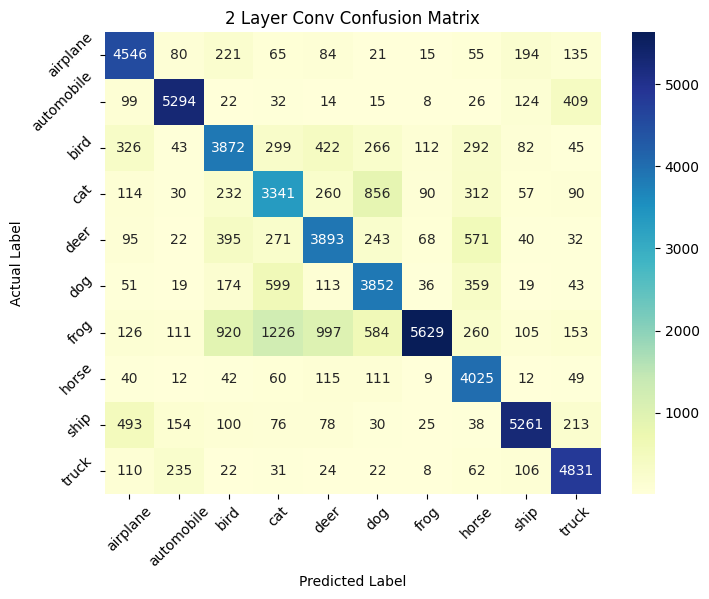

In [21]:
# Creating the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('2 Layer Conv Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()


In [22]:
print(classification_report(predictions, expected_labels, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.76      0.84      0.80      5416
  automobile       0.88      0.88      0.88      6043
        bird       0.65      0.67      0.66      5759
         cat       0.56      0.62      0.59      5382
        deer       0.65      0.69      0.67      5630
         dog       0.64      0.73      0.68      5265
        frog       0.94      0.56      0.70     10111
       horse       0.67      0.90      0.77      4475
        ship       0.88      0.81      0.84      6468
       truck       0.81      0.89      0.84      5451

    accuracy                           0.74     60000
   macro avg       0.74      0.76      0.74     60000
weighted avg       0.76      0.74      0.74     60000



#Problem 1.b

In [78]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        # Adding a new convolutional layer
        self.conv3 = nn.Conv2d(8, 4, kernel_size=3, padding=1)  # New layer
        self.act3 = nn.Tanh()
        self.pool3 = nn.MaxPool2d(2)  # New pooling layer
        # Adjust the input size for the first fully connected layer
        self.fc1 = nn.Linear(4 * 4 * 4, 32)  # Adjusted for new conv layer output
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        # Pass the output through the new conv layer
        out = self.pool3(self.act3(self.conv3(out)))
        out = out.view(-1, 4 * 4 * 4)  # Adjusted for new conv layer output
        out = self.act4(self.fc1(out))
        out = self.fc2(out)
        return out


In [79]:
model2 = Net2().to(device)

In [80]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18354, [432, 16, 1152, 8, 16384, 32, 320, 10])

In [81]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)

model2 = Net2().to(device=device)
optimizer2 = optim.SGD(model2.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer2,
    model = model2,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-12-12 07:39:23.815951 Epoch 1, Training loss 2.1790317624731137
2023-12-12 07:39:39.327071 Epoch 2, Training loss 2.0130565538430765
2023-12-12 07:40:09.865657 Epoch 4, Training loss 1.8026186029624451
2023-12-12 07:40:46.200589 Epoch 6, Training loss 1.5957095351670405
2023-12-12 07:41:17.141064 Epoch 8, Training loss 1.4861633019983922
2023-12-12 07:41:47.469602 Epoch 10, Training loss 1.4081529291999308
2023-12-12 07:42:18.427390 Epoch 12, Training loss 1.3559277421983003
2023-12-12 07:42:50.086237 Epoch 14, Training loss 1.3143094544825347
2023-12-12 07:43:21.468714 Epoch 16, Training loss 1.28187413273565
2023-12-12 07:43:52.653399 Epoch 18, Training loss 1.2517708120748514
2023-12-12 07:44:23.308071 Epoch 20, Training loss 1.2252586416881104
2023-12-12 07:44:53.754672 Epoch 22, Training loss 1.20161061084179
2023-12-12 07:45:24.493350 Epoch 24, Training loss 1.1817503672883944
2023-12-12 07:45:55.673525 Epoch 26, Training loss 1.1643364339533364
2023-12-12 07:46:26.217669 Ep

In [82]:
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=False)


In [83]:
accuracy2, predictions2, expected_labels2 = validate(model2, train_loader, val_loader)

Accuracy train: 0.66
Accuracy val: 0.62


In [84]:
precision2 = precision_score(predictions2, expected_labels2, average='macro')
recall2 = recall_score(predictions2, expected_labels2, average='macro')
cnf_matrix2 = confusion_matrix(predictions2, expected_labels2)

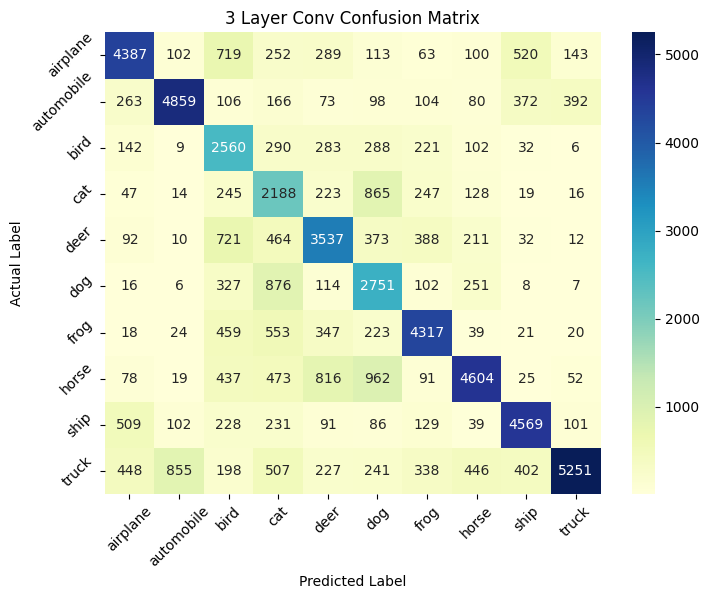

In [85]:
# Creating the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix2, annot=True, cmap="YlGnBu", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('3 Layer Conv Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()


In [86]:
print(classification_report(predictions2, expected_labels2, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.73      0.66      0.69      6688
  automobile       0.81      0.75      0.78      6513
        bird       0.43      0.65      0.52      3933
         cat       0.36      0.55      0.44      3992
        deer       0.59      0.61      0.60      5840
         dog       0.46      0.62      0.53      4458
        frog       0.72      0.72      0.72      6021
       horse       0.77      0.61      0.68      7557
        ship       0.76      0.75      0.76      6085
       truck       0.88      0.59      0.70      8913

    accuracy                           0.65     60000
   macro avg       0.65      0.65      0.64     60000
weighted avg       0.69      0.65      0.66     60000

